In [1]:
import pandas as pd, numpy as np, os
from get_draws.api import get_draws
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
output_dir ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v7.1.1_short_test/ciff_sam/2022_03_07_15_03_18/count_data/'

In [3]:
figname = 'model_7.0.0'

In [4]:
os.listdir(output_dir)

['wasting_transition_count.hdf',
 'diarrhea_transition_count.csv',
 'wasting_transition_count.csv',
 'diarrhea_state_person_time.hdf',
 'wasting_state_person_time.hdf',
 'deaths.csv',
 'diarrhea_state_person_time.csv',
 'wasting_state_person_time.csv',
 'deaths.hdf',
 'disease_transition_count.csv',
 'births.csv',
 'population.csv',
 'stunting_state_person_time.hdf',
 'ylds.csv',
 'ylls.csv',
 'disease_state_person_time.csv',
 'population.hdf',
 'diarrhea_transition_count.hdf',
 'ylls.hdf',
 'ylds.hdf',
 'disease_state_person_time.hdf',
 'births.hdf',
 'disease_transition_count.hdf',
 'stunting_state_person_time.csv']

In [5]:
state_pt = pd.read_csv(output_dir + 'disease_state_person_time.csv')
transitions = pd.read_csv(output_dir + 'disease_transition_count.csv')
deaths = pd.read_csv(output_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,value,wasting_state,age
0,0,female,2022,diarrheal_diseases,death,29,baseline,1.0,susceptible_to_child_wasting,early_neonatal
1,1,female,2022,diarrheal_diseases,death,29,baseline,0.0,mild_child_wasting,early_neonatal
2,2,female,2022,diarrheal_diseases,death,29,baseline,0.0,moderate_acute_malnutrition,early_neonatal
3,3,female,2022,diarrheal_diseases,death,29,baseline,1.0,severe_acute_malnutrition,early_neonatal
4,4,female,2022,diarrheal_diseases,death,29,baseline,3.0,susceptible_to_child_wasting,late_neonatal


In [6]:
state_pt

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,value,wasting_state,age
0,0,female,2022,lower_respiratory_infections,state_person_time,29,baseline,0.045175,susceptible_to_child_wasting,early_neonatal
1,1,female,2022,lower_respiratory_infections,state_person_time,29,baseline,0.006845,mild_child_wasting,early_neonatal
2,2,female,2022,lower_respiratory_infections,state_person_time,29,baseline,0.001369,moderate_acute_malnutrition,early_neonatal
3,3,female,2022,lower_respiratory_infections,state_person_time,29,baseline,0.000000,severe_acute_malnutrition,early_neonatal
4,4,female,2022,lower_respiratory_infections,state_person_time,29,baseline,0.453114,susceptible_to_child_wasting,late_neonatal
...,...,...,...,...,...,...,...,...,...,...
2107,2107,male,2022,susceptible_to_measles,state_person_time,946,baseline,333.136208,severe_acute_malnutrition,12_to_23_months
2108,2108,male,2022,susceptible_to_measles,state_person_time,946,baseline,21062.611910,susceptible_to_child_wasting,2_to_4
2109,2109,male,2022,susceptible_to_measles,state_person_time,946,baseline,6372.854209,mild_child_wasting,2_to_4
2110,2110,male,2022,susceptible_to_measles,state_person_time,946,baseline,2335.386721,moderate_acute_malnutrition,2_to_4


In [7]:
groupby_cols = ['input_draw','wasting_state']

In [8]:
def calculate_transition_rates(groupby_cols):
    trans = transitions.loc[transitions.scenario=='baseline']
    trans['cause'] = trans['measure'].str.split('to_', expand=True)[2].str.split('_event_count', expand=True)[0]
    trans['measure'] = np.where(trans.measure.str.contains('to_susceptible_to'),'remission','incidence')
    trans = trans.groupby(groupby_cols+['cause','measure']).sum()
    pt = (state_pt.loc[state_pt.cause.str.contains('measles')]
          .loc[state_pt.scenario=='baseline']
          .groupby(groupby_cols).sum())
    trans = (trans / pt)[['value']]
    trans = trans#.groupby([c for c in groupby_cols if c != 'input_draw'] + ['cause','measure']).describe(percentiles=[0.025,0.975])
    return trans

In [9]:
def calculate_incidence_rrs(strata_cols):
    t = calculate_transition_rates(strata_cols + ['input_draw','wasting_state']).reset_index()
    t = t.loc[t.measure=='incidence']
    tmrel = t.loc[t.wasting_state=='susceptible_to_child_wasting'].set_index(strata_cols + ['input_draw','cause'])[['value']]
    t = t.set_index(strata_cols + ['input_draw','cause','wasting_state'])[['value']] / tmrel
    t = t.groupby(strata_cols + ['cause','wasting_state']).describe(percentiles=[0.025,0.975])
    return t

In [10]:
calculate_incidence_rrs([])

value            \
                                                          count      mean   
cause                        wasting_state                                  
lower_respiratory_infections mild_child_wasting            11.0  1.843694   
                             moderate_acute_malnutrition   11.0  4.264186   
                             severe_acute_malnutrition     11.0  8.267553   
                             susceptible_to_child_wasting  11.0  1.000000   
measles                      mild_child_wasting            11.0  1.005373   
                             moderate_acute_malnutrition   11.0  2.644331   
                             severe_acute_malnutrition     11.0  8.610034   
                             susceptible_to_child_wasting  11.0  1.000000   

                                                                               \
                                                                std       min   
cause                        wasting_state                                      
lower_respiratory_infections mild_child_wasting            0.299442  1.416035   
                             moderate_acute_malnutrition   0.663125  3.209648   
                             severe_acute_malnutrition     1.846876  5.779044   
                             susceptible_to_child_wasting  0.000000  1.000000   
measles                      mild_child_wasting            0.181483  0.733656   
                             moderate_acute_malnutrition   0.618666  1.394789   
                             severe_acute_malnutrition     1.852806  5.839594   
                             susceptible_to_child_wasting  0.000000  1.000000   

                                                                               \
                                                               2.5%       50%   
cause                        wasting_state                                      
lower_respiratory_infections mild_child_wasting            1.445664  1.831397   
                             moderate_acute_malnutrition   3.216121  4.297713   
                             severe_acute_malnutrition     5.842948  8.128422   
                             susceptible_to_child_wasting  1.000000  1.000000   
measles                      mild_child_wasting            0.749689  1.034293   
                             moderate_acute_malnutrition   1.472915  2.902292   
                             severe_acute_malnutrition     5.942476  8.814729   
                             susceptible_to_child_wasting  1.000000  1.000000   

                                                                      \
                                                               97.5%   
cause                        wasting_state                             
lower_respiratory_infections mild_child_wasting             2.376209   
                             moderate_acute_malnutrition    5.255632   
                             severe_acute_malnutrition     11.347202   
                             susceptible_to_child_wasting   1.000000   
measles                      mild_child_wasting             1.290762   
                             moderate_acute_malnutrition    3.316593   
                             severe_acute_malnutrition     11.344128   
                             susceptible_to_child_wasting   1.000000   

                                                                      
                                                                 max  
cause                        wasting_state                            
lower_respiratory_infections mild_child_wasting             2.424260  
                             moderate_acute_malnutrition    5.406362  
                             severe_acute_malnutrition     11.969268  
                             susceptible_to_child_wasting   1.000000  
measles                      mild_child_wasting             1.311082  
                             moderate_acute_malnutrition    3.374

In [11]:
incidence_rrs = calculate_incidence_rrs(['age','sex'])
incidence_rrs

value  \
                                                                               count   
age           sex    cause                        wasting_state                        
1-5_months    female lower_respiratory_infections mild_child_wasting            11.0   
                                                  moderate_acute_malnutrition   11.0   
                                                  severe_acute_malnutrition     11.0   
                                                  susceptible_to_child_wasting  11.0   
                     measles                      mild_child_wasting            11.0   
...                                                                              ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  11.0   
                     measles                      mild_child_wasting             0.0   
                                                  moderate_acute_malnutrition    0.0   
                                                  severe_acute_malnutrition      0.0   
                                                  susceptible_to_child_wasting   0.0   

                                                                                          \
                                                                                    mean   
age           sex    cause                        wasting_state                            
1-5_months    female lower_respiratory_infections mild_child_wasting            1.042187   
                                                  moderate_acute_malnutrition   0.986180   
                                                  severe_acute_malnutrition     1.088643   
                                                  susceptible_to_child_wasting  1.000000   
                     measles                      mild_child_wasting            0.879454   
...                                                                                  ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  1.000000   
                     measles                      mild_child_wasting                 NaN   
                                                  moderate_acute_malnutrition        NaN   
                                                  severe_acute_malnutrition          NaN   
                                                  susceptible_to_child_wasting       NaN   

                                                                                          \
                                                                                     std   
age           sex    cause                        wasting_state                            
1-5_months    female lower_respiratory_infections mild_child_wasting            0.135316   
                                                  moderate_acute_malnutrition   0.197566   
                                                  severe_acute_malnutrition     0.559675   
                                                  susceptible_to_child_wasting  0.000000   
                     measles                      mild_child_wasting            0.262570   
...                                                                                  ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  0.000000   
                     measles                      mild_child_wasting                 NaN   
                                                  moderate_acute_malnutrition        NaN   
                                                  severe_acute_malnutrition          NaN   
                                                  susceptible_to_child_wasting       NaN   

                                                                                          \
                                                                                     min   
age           sex    cause                        wasting_state                     

In [12]:
# artifact
from vivarium import Artifact
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf',
               filter_terms=['year_start == 2020', f'age_end <= 5'])

In [13]:
wasting_rrs = art.load('risk_factor.child_wasting.relative_risk')

In [14]:
wasting_rrs = (art.load('risk_factor.child_wasting.relative_risk')
               .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
               .reset_index())
wasting_rrs['age'] = np.where(wasting_rrs['age_start'] == 0, 'early_neonatal', #1
                                            np.where(wasting_rrs['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(wasting_rrs['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(wasting_rrs['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(wasting_rrs['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2

wasting_rrs.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,count,mean,std,min,2.5%,50%,97.5%,max,age
0,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat1,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
1,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat2,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
2,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat3,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
3,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat4,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
4,Female,0.0,0.019178,2020,2021,lower_respiratory_infections,incidence_rate,cat1,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal


In [15]:
def plot_incidence_relative_risks(age, sex, cause, measure):
    width=0.4
    if measure == 'incidence_rate':
        s = incidence_rrs.reset_index()
    elif measure == 'CSMR':
        s = csmr_rrs.reset_index()
    s = s.loc[(s.sex==sex)
             &(s.age==age)
             &(s.cause==cause)]

    s['order'] = np.where(s.wasting_state.str.contains('suscept'), 0,
                         np.where(s.wasting_state.str.contains('mild'), 1,
                                 np.where(s.wasting_state.str.contains('moder'), 2, 3)))
    s = s.sort_values(by='order')
    plt.figure(dpi=120)
    plt.bar([0,1,2,3], s['value','mean'], yerr=s['value','std'], width=width, label='Simulation')

    a = wasting_rrs.reset_index()
    a = a.loc[(a.sex==sex.capitalize())
             &(a.age==age)
             &(a.affected_entity==cause)]

    a = a.sort_values(by='parameter', ascending=False)
    plt.bar([0.5,1.5,2.5,3.5], a['mean'], yerr=a['std'], width=width, label='Artifact')


    plt.title(f'{cause} {measure} relative risks\n{age} {sex}s')
    plt.legend(loc='upper left')
    plt.xticks([0.25, 1.25, 2.25, 3.25], a.parameter)

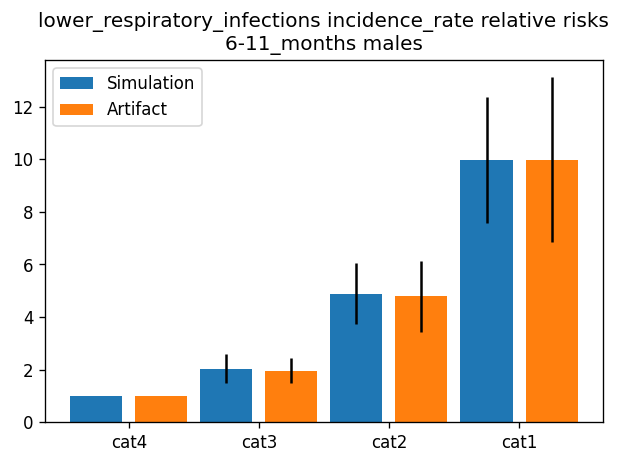

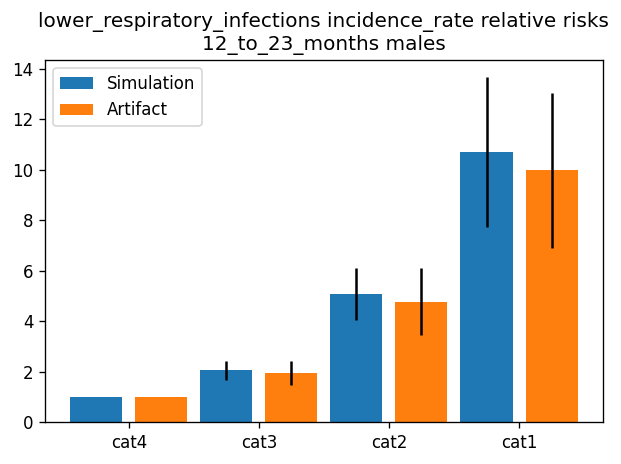

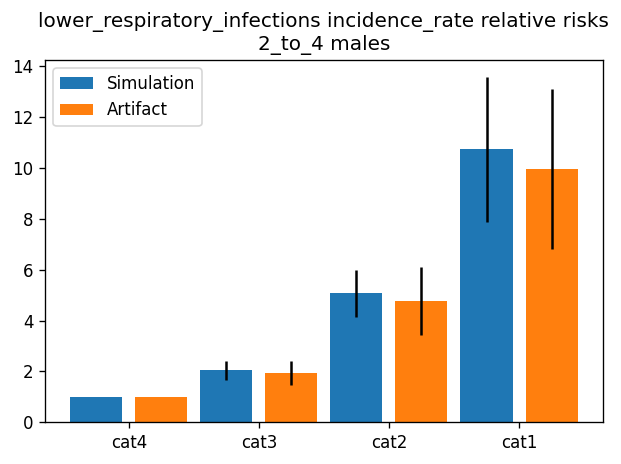

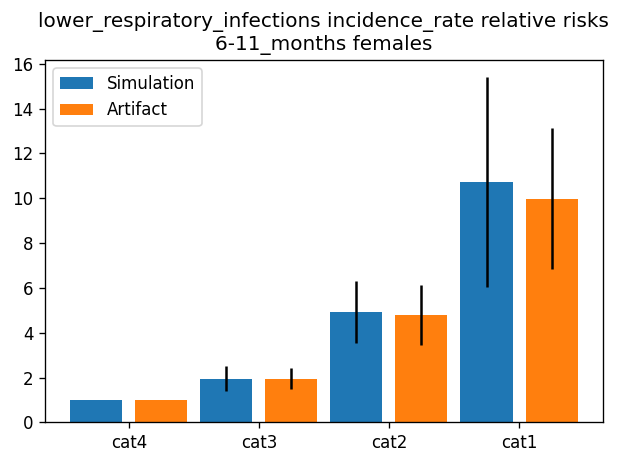

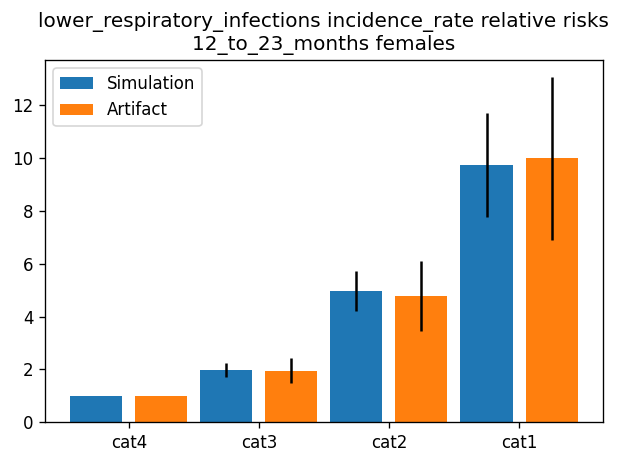

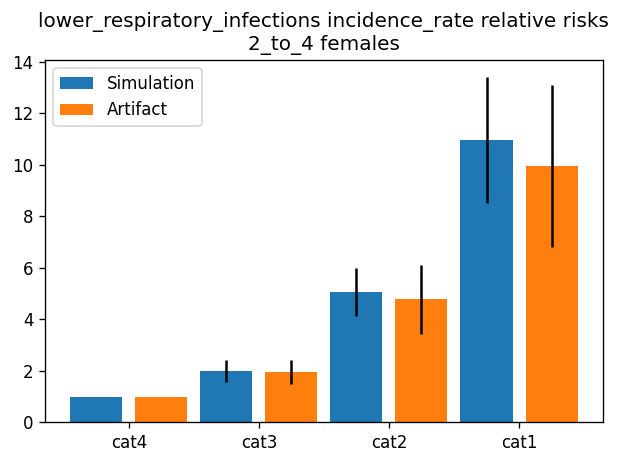

In [16]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'lower_respiratory_infections', 'incidence_rate')

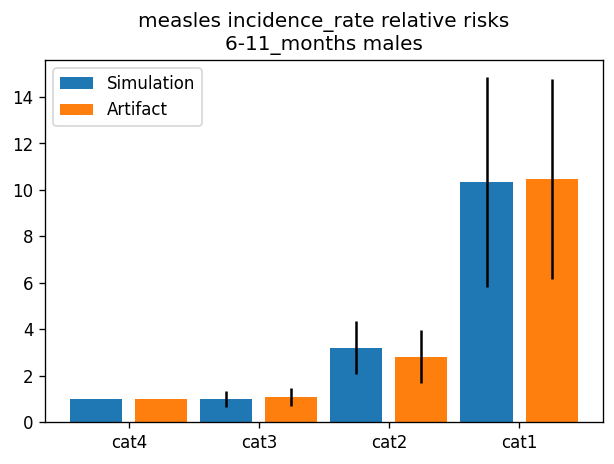

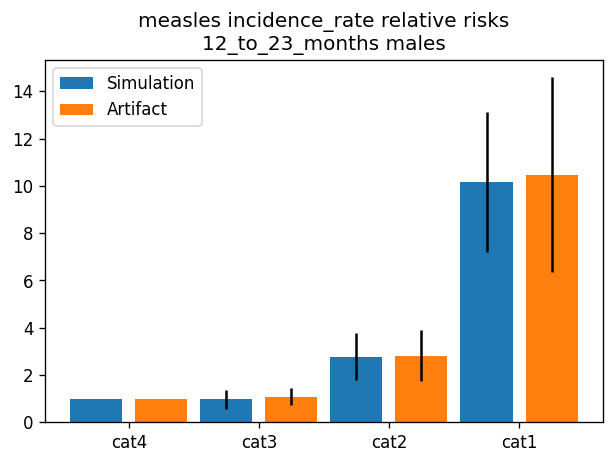

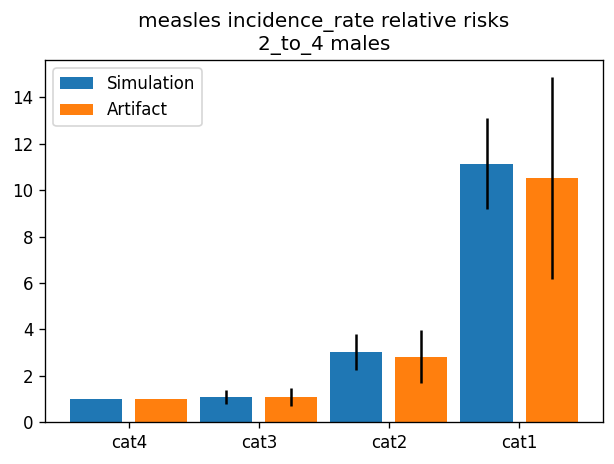

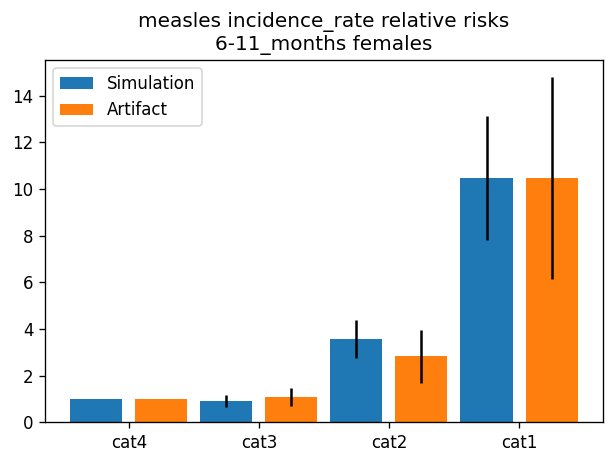

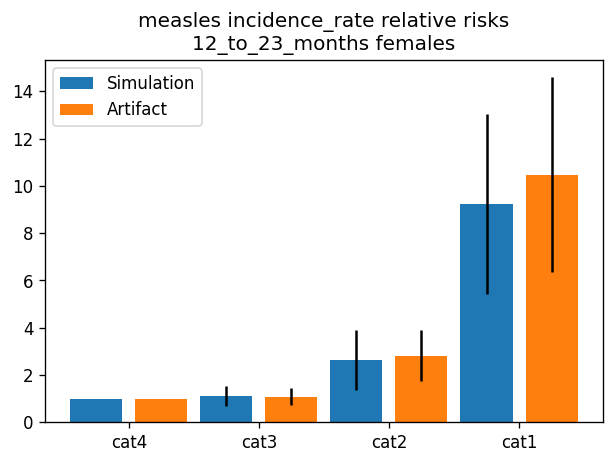

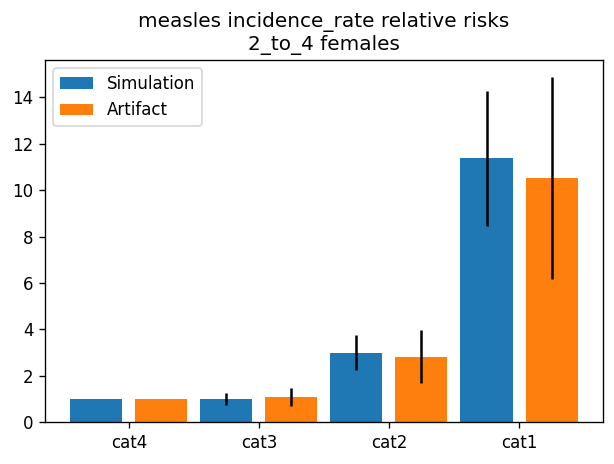

In [17]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'measles', 'incidence_rate')

In [18]:
# diarrheal incidence rrs
dt = pd.read_csv(output_dir + 'diarrhea_transition_count.csv')
dpt = pd.read_csv(output_dir + 'diarrhea_state_person_time.csv')

In [19]:
cols = ['age','sex']

a = ((dt.loc[(dt.measure=='susceptible_to_diarrheal_diseases_to_diarrheal_diseases_event_count')].groupby(['input_draw','wasting_state']+cols).sum()[['value']])
/ (dpt.loc[(dpt.cause=='susceptible_to_diarrheal_diseases')]
  .groupby(['input_draw','wasting_state']+cols).sum()[['value']])).reset_index()
ab = a.loc[a.wasting_state=='susceptible_to_child_wasting']
rrs = (a.set_index(['input_draw'] + cols + ['wasting_state'])
       / a.set_index(['input_draw'] + cols)[['value']])
rrs.groupby(['age','sex','wasting_state']).describe()

value                      \
                                                    count      mean       std   
age             sex    wasting_state                                            
1-5_months      female mild_child_wasting            44.0  0.981773  0.040106   
                       moderate_acute_malnutrition   44.0  1.001763  0.040604   
                       severe_acute_malnutrition     44.0  1.031481  0.067275   
                       susceptible_to_child_wasting  44.0  0.990177  0.038481   
                male   mild_child_wasting            44.0  1.017623  0.042843   
                       moderate_acute_malnutrition   44.0  0.996926  0.037995   
                       severe_acute_malnutrition     44.0  0.993241  0.048959   
                       susceptible_to_child_wasting  44.0  0.995783  0.035646   
12_to_23_months female mild_child_wasting            44.0  0.980773  0.051407   
                       moderate_acute_malnutrition   44.0  1.032172  0.065194   
                       severe_acute_malnutrition     44.0  1.046743  0.073048   
                       susceptible_to_child_wasting  44.0  0.950528  0.051781   
                male   mild_child_wasting            44.0  0.993121  0.040190   
                       moderate_acute_malnutrition   44.0  1.031032  0.042993   
                       severe_acute_malnutrition     44.0  1.020857  0.058625   
                       susceptible_to_child_wasting  44.0  0.960725  0.042914   
2_to_4          female mild_child_wasting            44.0  0.983365  0.043748   
                       moderate_acute_malnutrition   44.0  1.033220  0.048911   
                       severe_acute_malnutrition     44.0  1.032325  0.059810   
                       susceptible_to_child_wasting  44.0  0.957972  0.044633   
                male   mild_child_wasting            44.0  0.993513  0.038181   
                       moderate_acute_malnutrition   44.0  1.033698  0.042566   
                       severe_acute_malnutrition     44.0  1.014138  0.054369   
                       susceptible_to_child_wasting  44.0  0.963767  0.039357   
6-11_months     female mild_child_wasting            44.0  0.982589  0.039948   
                       moderate_acute_malnutrition   44.0  1.034600  0.052400   
                       severe_acute_malnutrition     44.0  1.006280  0.050656   
                       susceptible_to_child_wasting  44.0  0.981567  0.038978   
                male   mild_child_wasting            44.0  1.000866  0.036830   
                       moderate_acute_malnutrition   44.0  1.018767  0.045409   
                       severe_acute_malnutrition     44.0  1.002585  0.042548   
                       susceptible_to_child_wasting  44.0  0.981166  0.031465   
early_neonatal  female mild_child_wasting            44.0  1.032822  0.170377   
                       moderate_acute_malnutrition   44.0  0.971506  0.177010   
                       severe_acute_malnutrition     44.0  1.018330  0.233798   
                       susceptible_to_child_wasting  44.0  1.040597  0.157382   
                male   mild_child_wasting            44.0  1.037385  0.151840   
                       moderate_acute_malnutrition   44.0  1.008377  0.152463   
                       severe_acute_malnutrition     44.0  0.972348  0.197520   
                       susceptible_to_child_wasting  44.0  1.033436  0.149281   
late_neonatal   female mild_child_wasting            44.0  1.003028  0.083111   
                       moderate_acute_malnutrition   44.0  1.016266  0.105209   
                       severe_acute_malnutrition     44.0  0.988843  0.112703   
                       susceptible_to_child_wasting  44.0  1.010580  0.088481   
                male   mild_child_wasting            44.0  0.999286  0.062145   
                       moderate_acute_malnutrition   44.0  1.001202  0.058461   
                       severe_acute_malnutrition     44.0  1.004207  0.078877   
  

In [23]:
def calculate_csmr_rrs(strata_cols):
    d = deaths.reset_index()
    d = d.loc[(d.scenario=='baseline')
             &(d.cause.isin(['diarrheal_diseases',
                            'lower_respiratory_infections',
                            'measles']))
             #&(d.age.isin(['12_to_23_months','2_to_4']))
             ]
    d = d.groupby(strata_cols + ['input_draw','wasting_state','cause']).sum()[['value']]
    pt = (state_pt.loc[state_pt.cause.str.contains('measles')]
              .loc[(state_pt.scenario=='baseline')]
              .groupby(strata_cols + ['input_draw','wasting_state']).sum())[['value']]
    d = (d / pt).reset_index()
    d_tmrel = d.loc[d.wasting_state.str.contains('susc')].set_index(strata_cols + ['input_draw','cause'])[['value']]
    d = d.set_index(strata_cols + ['input_draw','cause','wasting_state']) / d_tmrel
    d = d.groupby(strata_cols + ['cause','wasting_state']).describe()
    return d

In [24]:
calculate_csmr_rrs([])

value            \
                                                          count      mean   
cause                        wasting_state                                  
diarrheal_diseases           mild_child_wasting            11.0  1.693688   
                             moderate_acute_malnutrition   11.0  4.393292   
                             severe_acute_malnutrition     11.0  9.961740   
                             susceptible_to_child_wasting  11.0  1.000000   
lower_respiratory_infections mild_child_wasting            11.0  1.448009   
                             moderate_acute_malnutrition   11.0  2.736889   
                             severe_acute_malnutrition     11.0  6.063884   
                             susceptible_to_child_wasting  11.0  1.000000   
measles                      mild_child_wasting            11.0  0.749588   
                             moderate_acute_malnutrition   11.0  2.546259   
                             severe_acute_malnutrition     11.0  8.067469   
                             susceptible_to_child_wasting  11.0  1.000000   

                                                                               \
                                                                std       min   
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            0.415277  1.056263   
                             moderate_acute_malnutrition   1.799773  2.276050   
                             severe_acute_malnutrition     2.889453  6.293286   
                             susceptible_to_child_wasting  0.000000  1.000000   
lower_respiratory_infections mild_child_wasting            0.335483  0.828623   
                             moderate_acute_malnutrition   0.573034  1.669889   
                             severe_acute_malnutrition     2.181596  0.685840   
                             susceptible_to_child_wasting  0.000000  1.000000   
measles                      mild_child_wasting            0.628217  0.000000   
                             moderate_acute_malnutrition   2.045554  0.000000   
                             severe_acute_malnutrition     6.109266  0.000000   
                             susceptible_to_child_wasting  0.000000  1.000000   

                                                                     \
                                                                25%   
cause                        wasting_state                            
diarrheal_diseases           mild_child_wasting            1.457082   
                             moderate_acute_malnutrition   3.075634   
                             severe_acute_malnutrition     7.584887   
                             susceptible_to_child_wasting  1.000000   
lower_respiratory_infections mild_child_wasting            1.274957   
                             moderate_acute_malnutrition   2.235365   
                             severe_acute_malnutrition     5.156217   
                             susceptible_to_child_wasting  1.000000   
measles                      mild_child_wasting            0.184978   
                             moderate_acute_malnutrition   1.508483   
                             severe_acute_malnutrition     4.656042   
                             susceptible_to_child_wasting  1.000000   

                                                                      \
                                                                 50%   
cause                        wasting_state                             
diarrheal_diseases           mild_child_wasting             1.675703   
                             moderate_acute_malnutrition    4.369183   
                             severe_acute_malnutrition     10.319463   
                             susceptible_to_child_wasting   1.000000   
lower_respiratory_infections mild_child_wasting             1.501005   
                             moderate_acute_

In [25]:
csmr_rrs = calculate_csmr_rrs(['age','sex'])
csmr_rrs.head()

FloatingPointError: invalid value encountered in subtract

In [26]:
def plot_csmr_relative_risks(age, sex, cause, measure):
    width=0.4
    s = csmr_rrs.reset_index()
    s = s.loc[(s.sex==sex)
             &(s.age==age)
             &(s.cause==cause)]

    s['order'] = np.where(s.wasting_state.str.contains('suscept'), 0,
                         np.where(s.wasting_state.str.contains('mild'), 1,
                                 np.where(s.wasting_state.str.contains('moder'), 2, 3)))
    s = s.sort_values(by='order')
    plt.figure(dpi=120)
    plt.bar([0,1,2,3], s['value','mean'], yerr=s['value','std'], width=width, label='Simulation')

    a = wasting_rrs.reset_index()
    a = a.loc[(a.sex==sex.capitalize())
             &(a.age==age)
             &(a.affected_entity==cause)]

    a = a.sort_values(by='parameter', ascending=False)
    plt.bar([0.5,1.5,2.5,3.5], a['mean'], yerr=a['std'], width=width, label='Artifact')


    plt.title(f'{cause} {measure} relative risks\n{age} {sex}s')
    plt.legend(loc='upper left')
    plt.xticks([0.25, 1.25, 2.25, 3.25], a.parameter)

In [27]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'diarrheal_diseases', 'CSMR')

NameError: name 'csmr_rrs' is not defined

In [28]:
for sex in ['male','female']:
    for age in ['12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'lower_respiratory_infections', 'CSMR')

NameError: name 'csmr_rrs' is not defined

# so now EMRs

In [29]:
d = deaths.reset_index()
d = d.loc[(d.scenario=='baseline')&(d.cause=='diarrheal_diseases')]
d = d.groupby(['input_draw','sex','age','wasting_state']).sum()[['value']]
pt = state_pt.loc[(state_pt.cause=='diarrheal_diseases')
                 &(state_pt.scenario=='baseline')]
pt = pt.groupby(['input_draw','sex','age','wasting_state']).sum()[['value']]
emr = d/pt
emr_tmrel = (emr.reset_index().loc[emr.reset_index().wasting_state=='susceptible_to_child_wasting']
             .set_index(['input_draw','sex','age'])[['value']])
diarrhea_emr_rr = emr / emr_tmrel
diarrhea_emr_rr = diarrhea_emr_rr.groupby(['sex','age','wasting_state']).describe()
diarrhea_emr_rr.head()

value                   \
                                                    count mean std min 25%   
sex    age             wasting_state                                         
female 1-5_months      mild_child_wasting             0.0  NaN NaN NaN NaN   
                       moderate_acute_malnutrition    0.0  NaN NaN NaN NaN   
                       severe_acute_malnutrition      0.0  NaN NaN NaN NaN   
                       susceptible_to_child_wasting   0.0  NaN NaN NaN NaN   
       12_to_23_months mild_child_wasting             0.0  NaN NaN NaN NaN   

                                                                 
                                                    50% 75% max  
sex    age             wasting_state                             
female 1-5_months      mild_child_wasting           NaN NaN NaN  
                       moderate_acute_malnutrition  NaN NaN NaN  
                       severe_acute_malnutrition    NaN NaN NaN  
                       susceptible_to_child_wasting NaN NaN NaN  
       12_to_23_months mild_child_wasting           NaN NaN NaN

In [30]:
def plot_emr_rrs(age, sex):
    width=0.4
    measure = 'EMR'
    cause = 'diarrheal_diseases'
    s = diarrhea_emr_rr.reset_index()
    s = s.loc[(s.sex==sex)
             &(s.age==age)
             #&(s.cause==cause)
             ]

    s['order'] = np.where(s.wasting_state.str.contains('suscept'), 0,
                         np.where(s.wasting_state.str.contains('mild'), 1,
                                 np.where(s.wasting_state.str.contains('moder'), 2, 3)))
    s = s.sort_values(by='order')
    plt.figure(dpi=120)
    plt.bar([0,1,2,3], s['value','mean'], yerr=s['value','std'], width=width, label='Simulation')

    a = wasting_rrs.reset_index()
    a = a.loc[(a.sex==sex.capitalize())
             &(a.age==age)
             &(a.affected_entity==cause)]

    a = a.sort_values(by='parameter', ascending=False)
    plt.bar([0.5,1.5,2.5,3.5], a['mean'], yerr=a['std'], width=width, label='Artifact')


    plt.title(f'{cause} {measure} relative risks\n{age} {sex}s')
    plt.legend(loc='upper left')
    plt.xticks([0.25, 1.25, 2.25, 3.25], a.parameter)

FloatingPointError: invalid value encountered in reduce

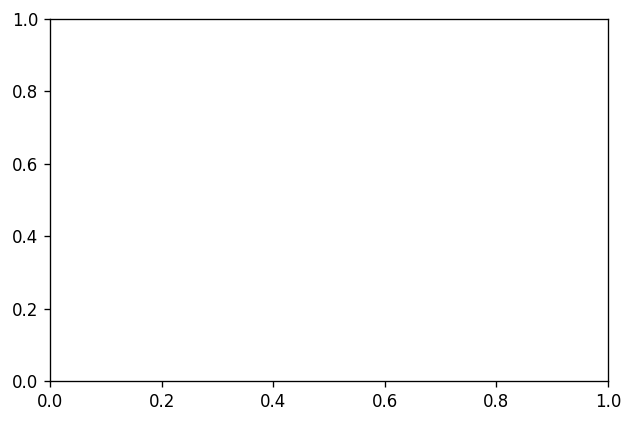

In [31]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
        plot_emr_rrs(age, sex)